In [24]:
# # when running for the first time

# !uv pip install git+https://github.com/kwotsin/mimicry.git
# !uv pip install pyro-ppl

In [25]:
import numpy as np
import torch
from torch import nn
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Categorical
import pyro
from pyro.infer import MCMC, HMC as pyro_hmc, NUTS as pyro_nuts
from matplotlib import pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple, Iterable, Callable, Union
from tqdm import tqdm, trange
from scipy.stats import gaussian_kde
from scipy.special import logsumexp
from pathlib import Path


from torchvision.utils import make_grid

# from torch_mimicry.nets import sngan

sns.set_theme('talk', style="white")

In [26]:
N_CHAINS = 10
N_SAMPLES = 1000
BURN_IN = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
def ema(series: Iterable, n: int) -> List:
    """
    returns an n period exponential moving average for
    the time series
    """
    series = np.array(series)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (series[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in series[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

In [28]:
def HMC(start,
        target,
        n_samples: int,
        burn_in: int,
        *,
        step_size: float,
        num_leapfrog_steps: float = 1,
        verbose: bool = False) -> torch.FloatTensor:
    """
    Hamiltonian Monte Carlo

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """

    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_hmc(
        potential_fn=energy, step_size=step_size, num_steps=num_leapfrog_steps, full_mass=False
        )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape).detach().cpu()

    return samples_true

In [29]:
def MALA(start: torch.FloatTensor,
        target,
        n_samples: int,
        burn_in: int,
        *,
        step_size: float,
        verbose: bool=False) -> Tuple[torch.FloatTensor, List]:
    """
    Metropolis-Adjusted Langevin Algorithm with Normal proposal

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        step_size - step size for drift term
        verbose - whether show iterations' bar

    Returns:
        sequence of slices per each iteration, acceptance rates per each iteration
    """
    std_normal = MNormal(torch.zeros(start.shape[-1], device=start.device), torch.eye(start.shape[-1], device=start.device))
    chains = []
    acceptance_rate = []

    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    grad_x = torch.autograd.grad(logp_x.sum(), x)[0]

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        noise =  torch.randn_like(x)
        y = x + step_size * grad_x + noise * (2 * step_size) ** .5

        logp_y = target.log_prob(y)
        grad_y = torch.autograd.grad(logp_y.sum(), y)[0]

        log_qyx = std_normal.log_prob(noise)
        log_qxy = std_normal.log_prob((x - y - step_size * grad_y) / (2 * step_size) ** .5)

        accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob

        with torch.no_grad():
            x[mask, :] = y[mask, :]
            logp_x[mask] = logp_y[mask]
            grad_x[mask] = grad_y[mask]

        acceptance_rate.append(mask.float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.cpu().clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

In [30]:
def ISIR(start: torch.FloatTensor,
        target,
        proposal,
        n_samples: int,
        burn_in: int,
        *,
        n_particles: int,
        verbose: bool=False) -> Tuple[List[torch.FloatTensor], List]:
    """
    Iterated Sampling Importance Resampling

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        n_particles - number of particles including one from previous step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []

    x = start.clone()
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        logqs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        logps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = logps - logqs.to(logps.device)
        indices = Categorical(logits=log_weights).sample()

        x = particles[np.arange(x.shape[0]), indices.to(x.device)].detach()
        logp_x = logps[np.arange(x.shape[0]), indices].detach()
        logq_x = logqs[np.arange(x.shape[0]), indices.to(logq_x.device)].detach()

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.cpu().clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

In [31]:
class TargetGAN(object):
    def __init__(
            self,
            gen: nn.Module,
            dis: nn.Module,
            device: Union[str, int, torch.device],
            batch_size: int = 128
            ):
        self.gen = gen
        self.dim = gen.latent_dim
        self.dis = dis
        self.device = device
        self.batch_size = batch_size

    def batch_log_prob(self, z: torch.FloatTensor):
        magic_const = 1 #try differnt ones here
        return  self.gen.prior.log_prob(z.to(self.device)) + magic_const * self.dis(self.gen(z.to(self.device))).squeeze()

    def log_prob(self, z: torch.FloatTensor, batch_size: Optional[int] = None):
        z_flat = z.reshape(-1, self.dim)
        batch_size = batch_size or self.batch_size
        return torch.cat(list(map(self.batch_log_prob, z_flat.split(batch_size, 0))), 0).reshape(z.shape[:-1])


Download the pre-trained DC-GAN model, architecure is taken from Mimicry repo.

In [32]:
# #!pip install --upgrade --no-cache-dir gdown

# ! if [ ! -f "cifar10_dcgan_G.pth" ]; then gdown 1k_DwjkprptuCXK_gJzFF9eUCHTD9vOUH; fi
# ! if [ ! -f "cifar10_dcgan_D.pth" ]; then gdown 1o6cXzpAPhGZxJOJseic8oGhsuilcLdLK; fi

DC-GAN architecture here

In [33]:
# DCGAN

from torch import nn


class DCGANGenerator(nn.Module):
    def __init__(
        self,
        ngpu=1,
        nc=3,
        nz=100,
        ngf=64,
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
    ):
        super().__init__()
        self.z_dim = self.latent_dim = nz
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        if input.ndim == 2:
            input = input[..., None, None]
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


class DCGANDiscriminator(nn.Module):
    def __init__(
        self,
        ngpu=1,
        nc=3,
        ndf=64,
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5),
        output_layer="sigmoid",
    ):
        super().__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)


batch_size = 64
gen = DCGANGenerator().to(device)
dis = DCGANDiscriminator().to(device)

gen.load_state_dict(torch.load('cifar10_dcgan_G.pth'))
dis.load_state_dict(torch.load('cifar10_dcgan_D.pth'))
gen.eval()
dis.eval();

prior = MNormal(
    torch.zeros(gen.latent_dim).to(device), torch.eye(gen.latent_dim).to(device)
    )

gen.prior = prior
gan_target = TargetGAN(gen, dis, device=device, batch_size=batch_size)

## Algorithm 

In [34]:
def MH(start: torch.FloatTensor,
       gen,
       dis,
       n_samples: int,
       burn_in: int,
       device):
    chains = []

    gen.eval()
    dis.eval()

    x = start.clone()
    batch_size = x.shape[0]
    z_dim = gen.latent_dim

    total_steps = n_samples + burn_in

    for step in trange(total_steps):
        with torch.no_grad():
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            x_prime = gen(z)
            
            D_x = torch.sigmoid(dis(x))
            D_xprime = torch.sigmoid(dis(x_prime))
            
            ratio = (1.0 / D_x - 1.0) / (1.0 / D_xprime - 1.0)
            
            U = torch.rand_like(ratio)

            accepted = (U <= ratio)

            x[accepted] = x_prime[accepted]
            
        
            if step >= burn_in:
                chains.append(x.detach().cpu().clone())
    
    chains = torch.stack(chains, 0)
    return chains


## Start from noise

In [35]:
N_CHAINS = 1000
N_SAMPLES = 200
BURN_IN = 0
start = gen(prior.sample((N_CHAINS,))).to(device)
chains = MH(start, gen, dis, n_samples=N_SAMPLES, burn_in=BURN_IN, device=device)


100%|██████████| 200/200 [00:04<00:00, 47.03it/s]


In [36]:
chains.shape

torch.Size([200, 1000, 3, 32, 32])

In [37]:
samples = chains[-1]

In [38]:
samples.shape

torch.Size([1000, 3, 32, 32])

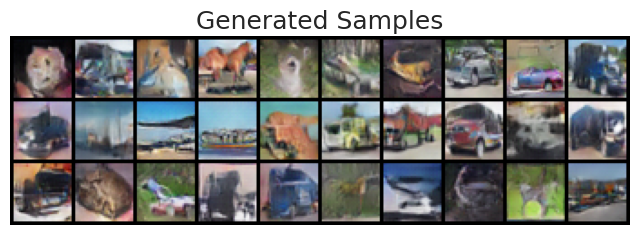

In [39]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def visualize_samples(samples, nrow=10, figsize=(8, 8), title="Generated Samples"):
    """
    Visualizes a batch of image samples arranged in a grid.
    
    Args:
        samples (Tensor): Tensor of shape [N, C, H, W].
        nrow (int): Number of images in each row of the grid.
        figsize (tuple): Size of the matplotlib figure.
        title (str): Title for the plot.
    """
    # If the images are in the range [-1, 1], transform them to [0, 1]
    if samples.min() < 0:
        samples = (samples + 1) / 2.0

    # Create a grid of images
    grid = make_grid(samples, nrow=nrow, padding=2, normalize=True)
    
    # Convert the grid from CxHxW to HxWxC and move to CPU for plotting
    grid_np = grid.permute(1, 2, 0).cpu().numpy()
    
    # Plot using matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(grid_np)
    plt.title(title)
    plt.axis('off')
    plt.show()


visualize_samples(samples[30:60], nrow=10)

Code to compute the Inception score:

In [17]:
import os
import random
import time

import numpy as np
import tensorflow as tf
import torch

from torch_mimicry.datasets.image_loader import get_dataset_images
from torch_mimicry.metrics.fid import fid_utils
from torch_mimicry.metrics.inception_model import inception_utils
from torch_mimicry.metrics.compute_fid import compute_real_dist_stats


def _normalize_images(images):
    """
    Given a tensor of images, uses the torchvision
    normalization method to convert floating point data to integers. See reference
    at: https://pytorch.org/docs/stable/_modules/torchvision/utils.html#save_image
    The function uses the normalization from make_grid and save_image functions.
    Args:
        images (Tensor): Batch of images of shape (N, 3, H, W).
    Returns:
        ndarray: Batch of normalized images of shape (N, H, W, 3).
    """
    # Shift the image from [-1, 1] range to [0, 1] range.
    min_val = float(images.min())
    max_val = float(images.max())
    images.clamp_(min=min_val, max=max_val)
    images.add_(-min_val).div_(max_val - min_val + 1e-5)

    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    #images = images.mul_(255).add_(0.5).clamp_(0, 255).permute(0, 2, 3, 1).to(
    #    'cpu', torch.uint8).numpy()
    # To preserve the same dimensions order
    images = images.mul_(255).add_(0.5).clamp_(0, 255).to('cpu', torch.uint8).numpy()

    return images

2025-03-21 23:24:15.038545: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 23:24:15.045103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 23:24:15.052229: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 23:24:15.054286: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 23:24:15.060273: I tensorflow/core/platform/cpu_feature_guar

In [18]:
# from https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score_mod(imgs, cuda=True, batch_size=32, resize=True, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))


    print("INFO: Inception Score: {:.4f} ± {:.4f}".
          format(np.mean(split_scores), np.std(split_scores)))

    return np.mean(split_scores), np.std(split_scores)

In [19]:
class DCGANDataset(torch.utils.data.Dataset):
    def __init__(self, images):
        self.images = images

    def __getitem__(self, idx):
        return self.images[idx]

    def __len__(self):
        return len(self.images)


In [25]:
for idx in range(0, 200, 20):
    images = []
    for i in range(1000):
        images.append(_normalize_images(chains[idx, i, :, :, :]).squeeze())
    dataset = DCGANDataset(images)
    # Same number of splits as in previously provided implementation of inception score calculation
    inception_score_mod(dataset, splits=10)

/home/br0fire/Progs/HSE_MC/HW4/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/br0fire/Progs/HSE_MC/HW4/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_152528/4071041442.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


INFO: Inception Score: 2.8250 ± 0.2095
INFO: Inception Score: 2.5721 ± 0.1496
INFO: Inception Score: 2.4495 ± 0.1594
INFO: Inception Score: 2.4428 ± 0.2467
INFO: Inception Score: 2.4146 ± 0.1946
INFO: Inception Score: 2.4519 ± 0.3253
INFO: Inception Score: 2.5465 ± 0.2451
INFO: Inception Score: 2.7123 ± 0.1795
INFO: Inception Score: 2.5460 ± 0.2808
INFO: Inception Score: 2.5526 ± 0.2420


## Start from train sample

In [12]:
# Data loading
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

# Normalization constants values were taken as in DC-GAN default params

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=False, transform=transform)



In [33]:
N_CHAINS = 1000
N_SAMPLES = 200
BURN_IN = 0
start = torch.stack([train_dataset[i][0] for i in np.random.choice(len(train_dataset), N_CHAINS)]).to(device)
chains = MH(start, gen, dis, n_samples=N_SAMPLES, burn_in=BURN_IN, device=device)


100%|██████████| 200/200 [00:04<00:00, 42.13it/s]


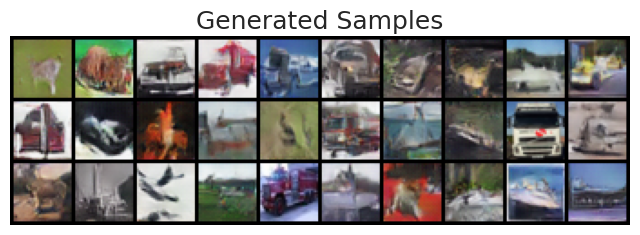

In [34]:
samples = chains[-1]
visualize_samples(samples[30:60], nrow=10)

In [35]:
for idx in range(0, 200, 20):
    images = []
    for i in range(1000):
        images.append(_normalize_images(chains[idx, i, :, :, :]).squeeze())
    dataset = DCGANDataset(images)
    # Same number of splits as in previously provided implementation of inception score calculation
    inception_score_mod(dataset, splits=10)

/home/br0fire/Progs/HSE_MC/HW4/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/br0fire/Progs/HSE_MC/HW4/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_152528/4071041442.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


INFO: Inception Score: 2.8793 ± 0.2200
INFO: Inception Score: 2.5412 ± 0.1787
INFO: Inception Score: 2.4265 ± 0.2662
INFO: Inception Score: 2.3461 ± 0.1855
INFO: Inception Score: 2.3054 ± 0.2225
INFO: Inception Score: 2.4172 ± 0.2647
INFO: Inception Score: 2.3571 ± 0.2895
INFO: Inception Score: 2.4086 ± 0.2288
INFO: Inception Score: 2.3895 ± 0.1634
INFO: Inception Score: 2.4481 ± 0.3008


In [13]:
import torch
import torch.nn as nn

def retrain_discriminator(generator, discriminator, dataset, device, num_epochs=50, batch_size=100, lr=1e-4):

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    generator.eval()  # Freeze generator during discriminator training
    discriminator.train()

    for epoch in trange(num_epochs):
        total_loss = 0.0

        for real_images, _ in dataloader:
            real_images = real_images.to(device)

            batch_size = real_images.size(0)

            # Real and fake labels
            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            # Forward pass real images
            real_preds = discriminator(real_images).squeeze()
            loss_real = criterion(torch.sigmoid(real_preds), real_labels)

            # Generate fake images
            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            with torch.no_grad():
                fake_images = generator(noise)

            # Forward pass fake images
            fake_preds = discriminator(fake_images).squeeze()
            loss_fake = criterion(torch.sigmoid(fake_preds), fake_labels)

            # Combine losses
            loss = loss_real + loss_fake

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Loss: {avg_loss}")

    return discriminator


In [14]:
dis = retrain_discriminator(gen, dis, train_dataset, device, num_epochs=10, batch_size=100, lr=1e-4)

 10%|█         | 1/10 [00:05<00:49,  5.48s/it]

Loss: 0.0027354920448215123


 20%|██        | 2/10 [00:10<00:42,  5.35s/it]

Loss: 0.0010331712942706873


 30%|███       | 3/10 [00:15<00:37,  5.31s/it]

Loss: 0.00011123260882357045


 40%|████      | 4/10 [00:21<00:31,  5.29s/it]

Loss: 2.2575052113722903e-05


 50%|█████     | 5/10 [00:26<00:26,  5.28s/it]

Loss: 1.685903318337978e-05


 60%|██████    | 6/10 [00:31<00:21,  5.27s/it]

Loss: 9.816632135645875e-06


 70%|███████   | 7/10 [00:37<00:15,  5.27s/it]

Loss: 8.932730357628315e-06


 80%|████████  | 8/10 [00:42<00:10,  5.27s/it]

Loss: 0.008197155552574628


 90%|█████████ | 9/10 [00:47<00:05,  5.27s/it]

Loss: 0.0003193475698959958


100%|██████████| 10/10 [00:52<00:00,  5.29s/it]

Loss: 5.034791924625637e-05


In [15]:
N_CHAINS = 1000
N_SAMPLES = 200
BURN_IN = 0
start = torch.stack([train_dataset[i][0] for i in np.random.choice(len(train_dataset), N_CHAINS)]).to(device)
chains = MH(start, gen, dis, n_samples=N_SAMPLES, burn_in=BURN_IN, device=device)


100%|██████████| 200/200 [00:04<00:00, 41.58it/s]


In [20]:
for idx in range(0, 200, 20):
    images = []
    for i in range(1000):
        images.append(_normalize_images(chains[idx, i, :, :, :]).squeeze())
    dataset = DCGANDataset(images)
    # Same number of splits as in previously provided implementation of inception score calculation
    inception_score_mod(dataset, splits=10)

/home/br0fire/Progs/HSE_MC/HW4/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/br0fire/Progs/HSE_MC/HW4/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_154608/3671731990.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


INFO: Inception Score: 2.9871 ± 0.3315
INFO: Inception Score: 3.0417 ± 0.2502
INFO: Inception Score: 3.0870 ± 0.2220
INFO: Inception Score: 2.9895 ± 0.2149
INFO: Inception Score: 3.0548 ± 0.1112
INFO: Inception Score: 3.0132 ± 0.2164
INFO: Inception Score: 3.0462 ± 0.1855
INFO: Inception Score: 3.0600 ± 0.3051
INFO: Inception Score: 3.1878 ± 0.3510
INFO: Inception Score: 3.1655 ± 0.2460


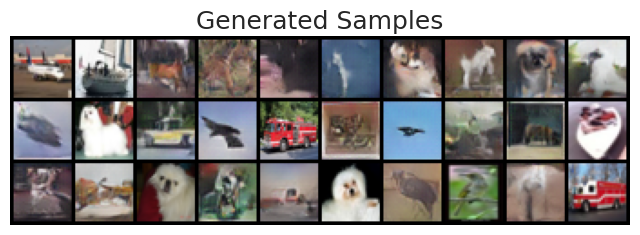

In [23]:
samples = chains[-1]
visualize_samples(samples[30:60], nrow=10)